In [3]:
import os.path as op
import sys
sys.path.append(op.abspath('../../'))

sys.path.append(op.abspath('../../../../'))

from os import environ
environ["ANAROOT"] = op.abspath('../../../../')

# Effect of some cuts on signal
We seek to analyse the effect of some cuts, supposedly efficient in signal, using the simulation.

## Libraries

In [4]:
import numpy as np
import models
import var, fcts

from project import files, defs, col
from lib import data, plot as lp, clustering


## Simulation

### Parameters

In [5]:
N = 100000
S = 100000
P = 100000


shift_pedestal = (600, 150)
amp_S = 30  # (25, 5)
std_N = 1.

# Peaked
n_peaks = (1, 6)  # between 1 and 6 peaks / event
amp_P = (1, 30)  # peak amplitude between 1 and 15
length_peaks = (1, 3)  # length of a peak between 1 and 3

shift_pedestal = (600, 150)

optimised = False

components = {
    "S": {"S": S, "amp_S": amp_S, "true_pedestal": True},
    "N": {"N": N, "std_N": std_N, "true_pedestal": True},
    "P": {
        "P": P, "n_peaks": n_peaks,
        "amp_P": amp_P, "length_peaks": length_peaks
    }
}

bdt_name = "BDT_SNP"

image_path = op.join(var.image_path, bdt_name)


### Simulation

In [6]:
rng = np.random.default_rng(12345)

dataframe = models.get_full_dataframe(
    components,
    shift_pedestal=shift_pedestal,
    random_time_shift=True,
    rng=rng
)

dataframe = files.compute_voi(
    dataframe,
    variables=defs.computed_variables +
    ['std_pos', 'std_neg']
)


Time taken: 1.1145350933074951


In [7]:
dataframe['mid'] = (dataframe['max'] + dataframe['min']) / 2

In [8]:
columns_already_computed = [
    'pos_max', 'pos_min',
    'std',
    'std_pos', 'std_neg',
]

columns_to_compute = [
    'max_m_mean',
    'mean_m_pedestal',
    'min_m_pedestal',
    'max_m_pedestal',
    'min_std_pos_neg',
    'max_std_pos_neg',
    'min_std_pos_neg_red',
    'max_std_pos_neg_red',
    'max_m_mean',
    'max_m_mean_red',
    'min_m_mean', 'min_m_mean_red',
    'median_m_mean', 'median_m_mean_red',
    'mid_m_mean', 'mid_m_mean_red'
]

new_columns = ['mean_before_end_peak', 'mean_after_end_peak', 'pos_first_neg_after_max']
columns_to_compute += ['mean_before_end_peak_red', 'mean_after_end_peak_red']

In [9]:
files.compute_peak_voi(dataframe, zero_column="mean", red=True) 
files.compute_threshold_voi(dataframe, ref_column="min", threshold=0.8) 

# Get the formula of the columns to compute
formula_columns = col.get_formula_columns(columns_to_compute)
formula_column_labels = col.get_formula_labels(
    columns_to_compute, defs.column_labels
)
column_labels = {**defs.column_labels, **formula_column_labels}

# Compute them
dataframe = data.compute_vals(dataframe, formula_columns)

Time taken: 0.3107285499572754
Time taken: 0.30283236503601074


In [11]:
dataframe_sig = dataframe.query("is_sig == True")

## 2D histograms to show the effect of the cuts

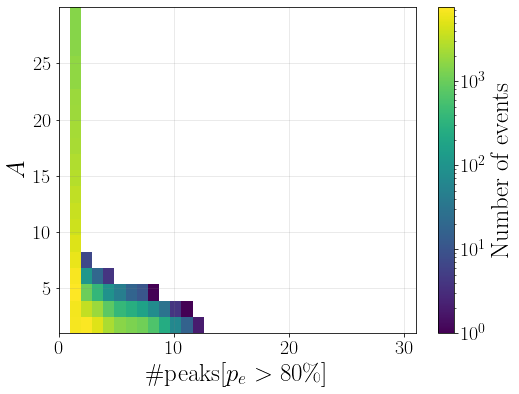

In [16]:
cut_variables = [
    "nb_peaks_sup_80_wrt_min"
]

prop_percent = 80
column_ranges = {
    'pos_max': [0, 31],
    'nb_max': [0, 31],
    f'nb_sup_{prop_percent}': [0, 31], 
    f'nb_peaks_sup_{prop_percent}_wrt_min': [0, 31], 
}
column_nbins = {
    'default': 20,
    'nb_max': 32,
    'pos_max': 32,
    f'nb_sup_{prop_percent}': 32,
    f'nb_peaks_sup_{prop_percent}_wrt_min': 32
}
column_labels[f"nb_sup_{prop_percent}"] = f"$\\# [p_e > {prop_percent}\\%]$"
column_labels[f"std_sup_{prop_percent}"] = f"$\\sigma[p_e > {prop_percent}\\%]$"
column_labels[f"nb_peaks_sup_{prop_percent}_wrt_min"] = f"$\\# \\text{{peaks}}[p_e > {prop_percent}\\%]$"
column_labels["amp_S"] = "$A$"


name_var2 = "amp_S"
for name_var1 in cut_variables:
    min_max = [None, None]
    bins = [None, None]

    if name_var1 in column_ranges:
        min_max[0] = column_ranges[name_var1]
    if name_var2 in column_ranges:
        min_max[1] = column_ranges[name_var2]

    bins[0] = column_nbins.get(name_var1, column_nbins['default'])
    bins[1] = column_nbins.get(name_var2, column_nbins['default'])

    if bins==[None, None]:
        bins = None


    lp.plot_hist2d(
        dataframe_sig[name_var1], dataframe_sig[name_var2],
        column_labels[name_var1], column_labels[name_var2],
        logscale=True,
        min_max=min_max,
        bins=bins
    )    

What about the signal events that would not satisfy the cut ?

In [21]:
dataframe_sig_2 = dataframe_sig.query("nb_peaks_sup_80_wrt_min == 2 and max_m_mean > 4")
dataframe_sig_2_sample = dataframe_sig_2.sample(100)

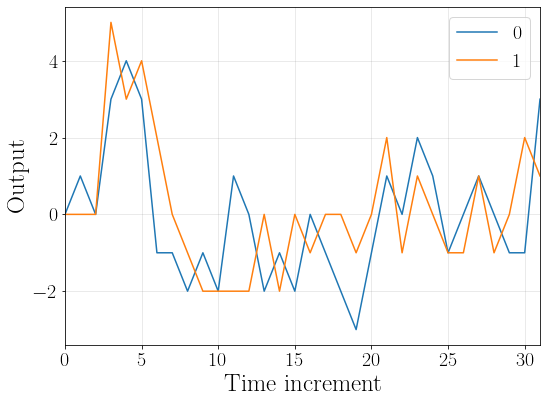

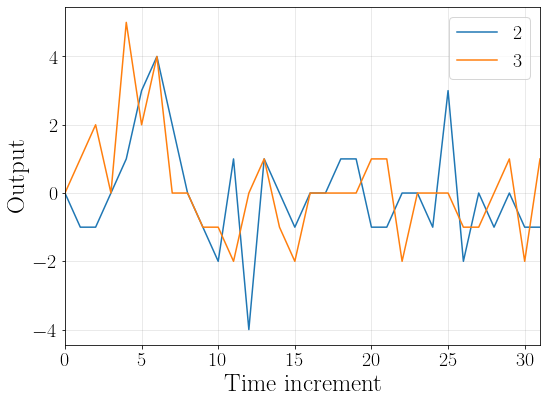

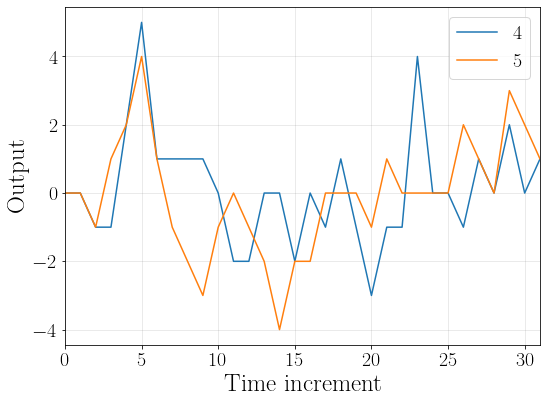

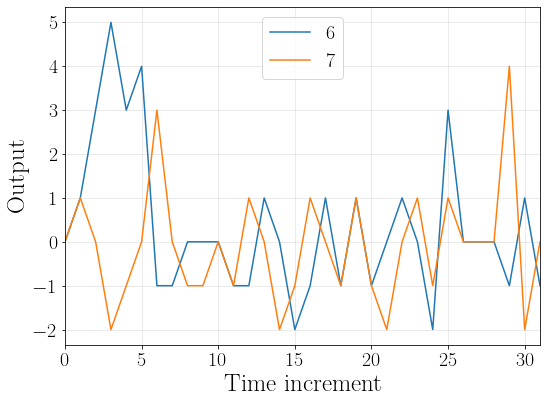

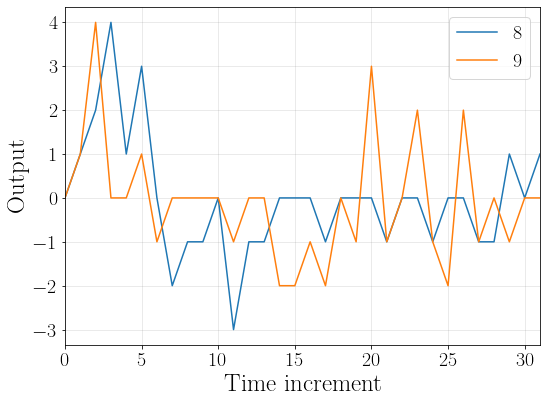

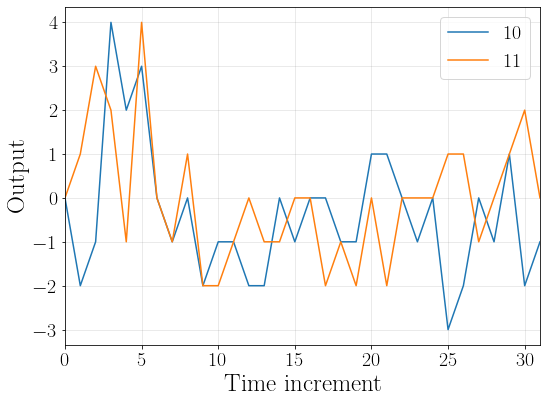

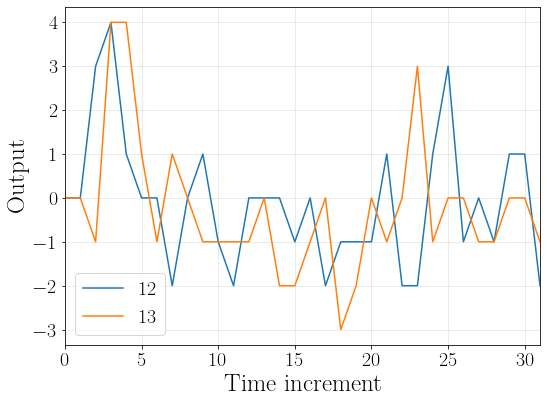

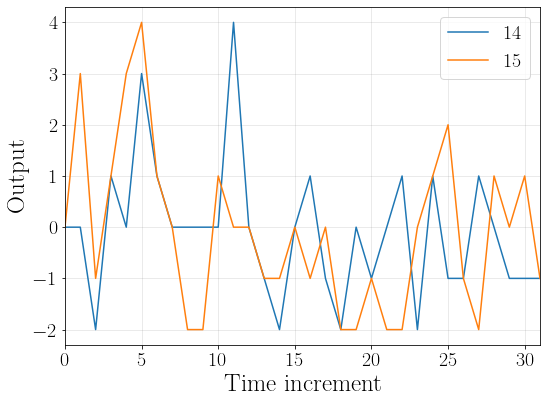

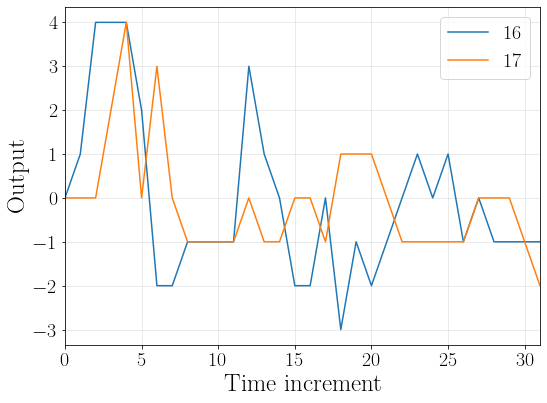

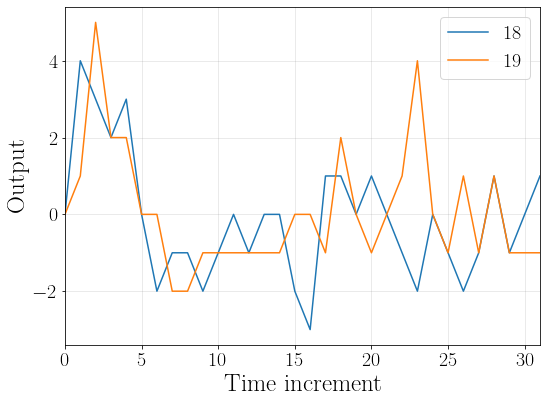

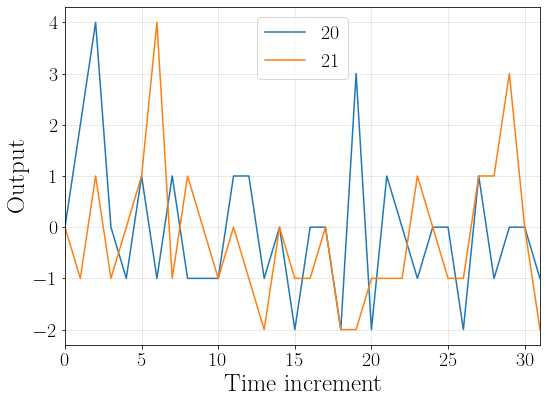

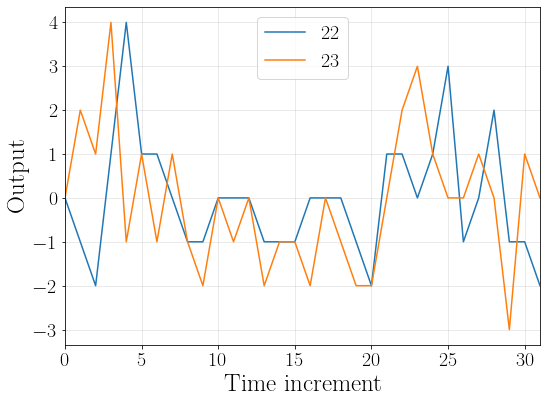

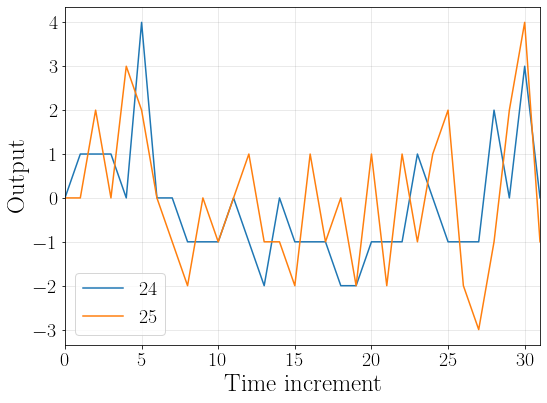

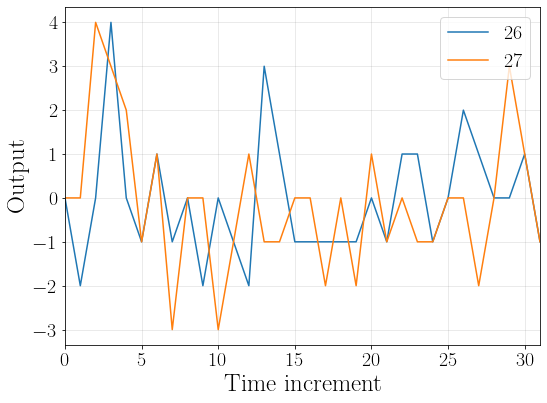

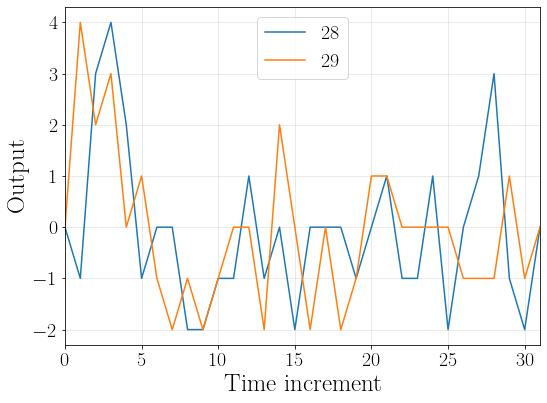

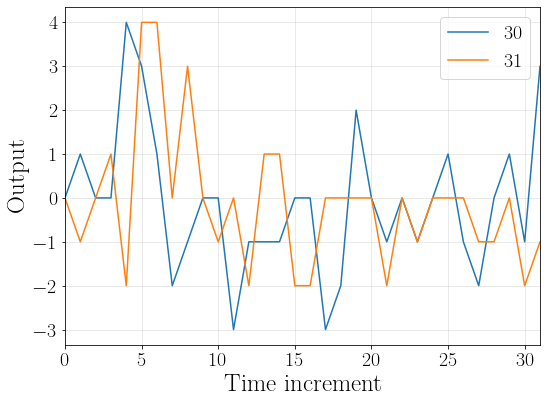

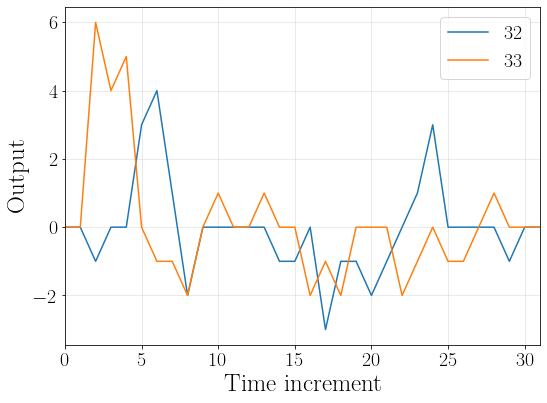

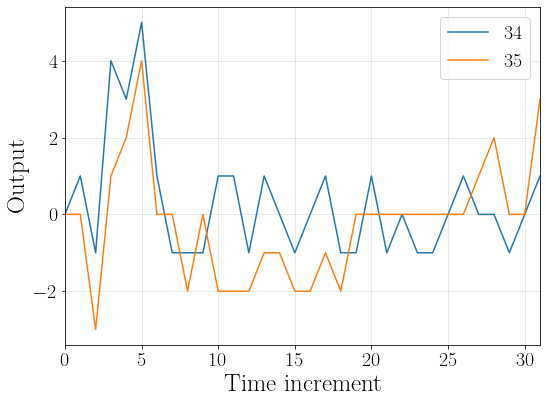

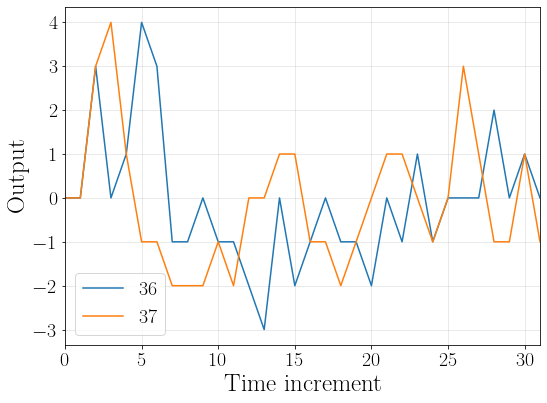

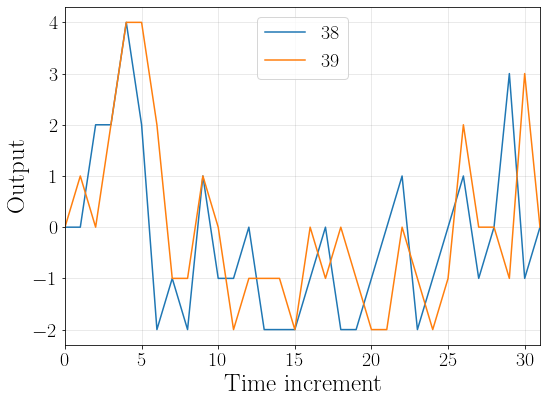

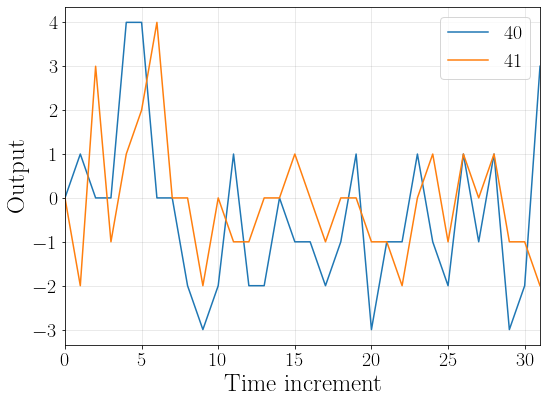

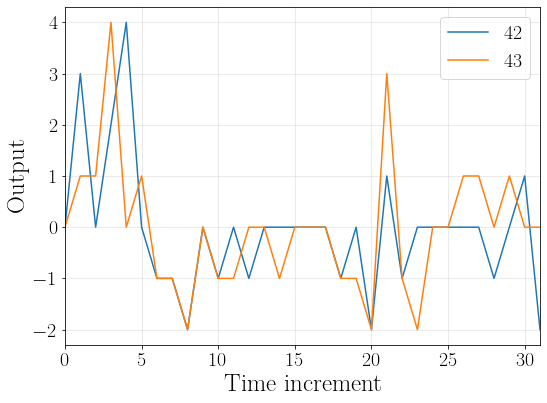

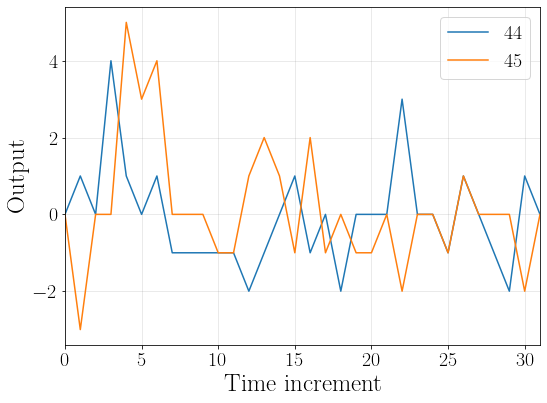

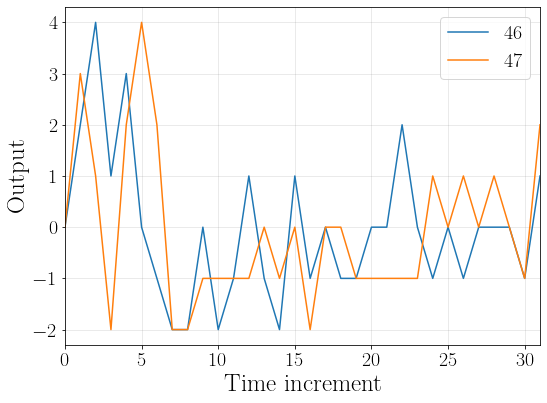

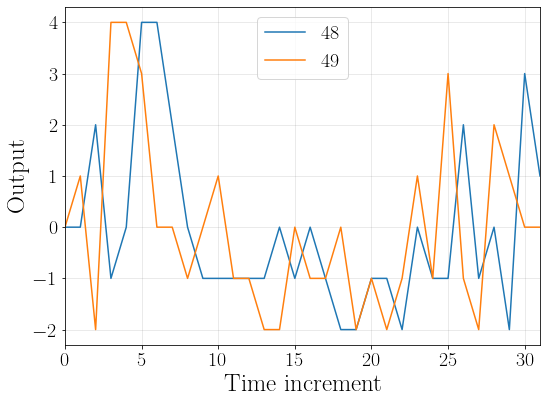

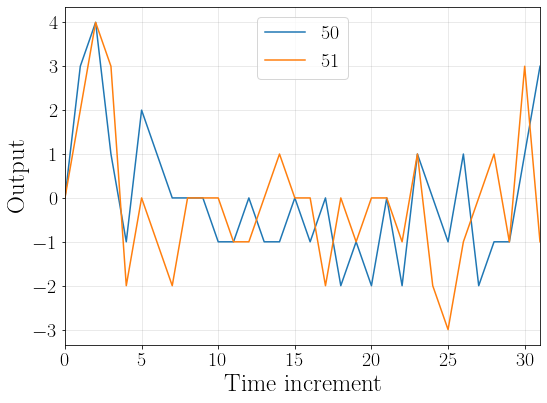

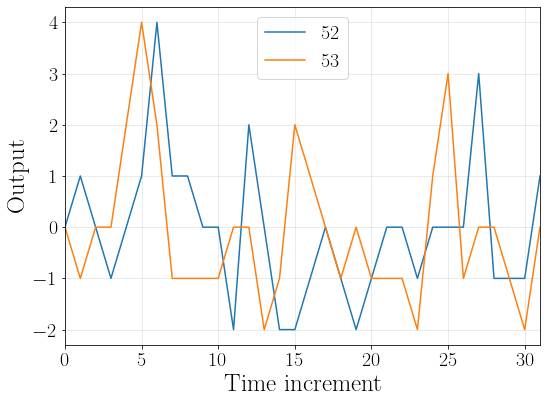

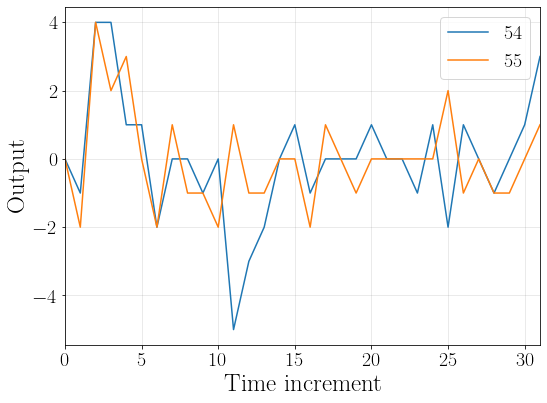

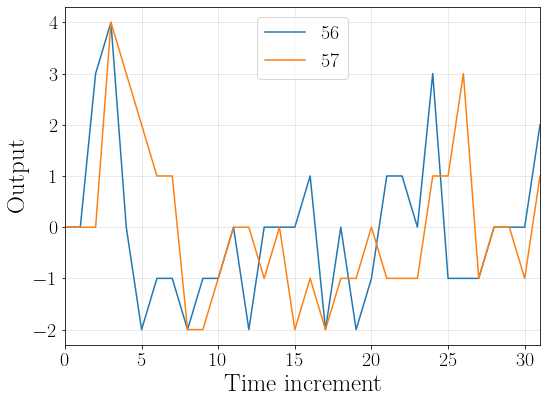

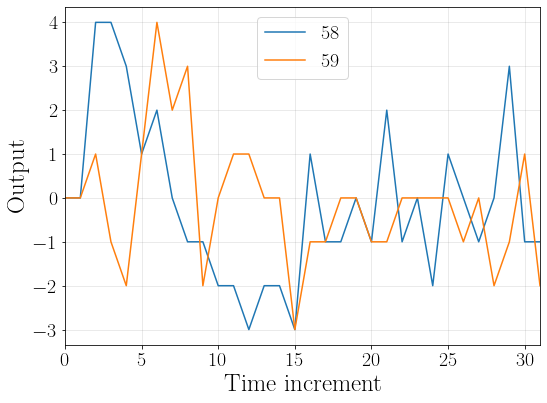

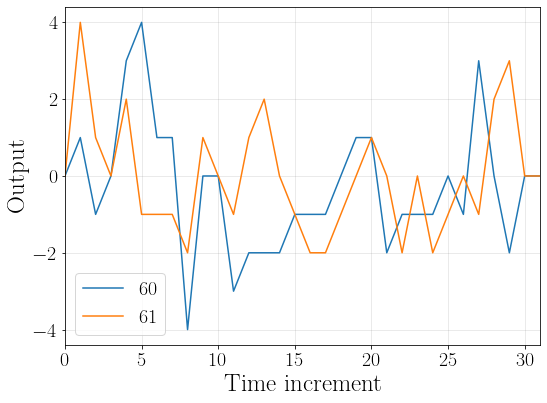

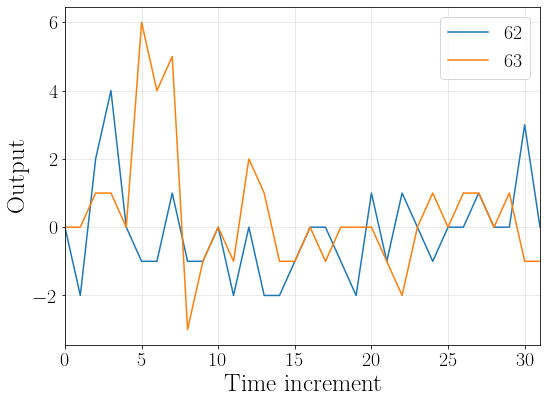

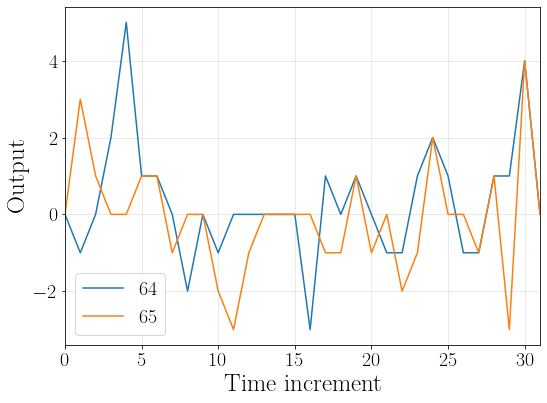

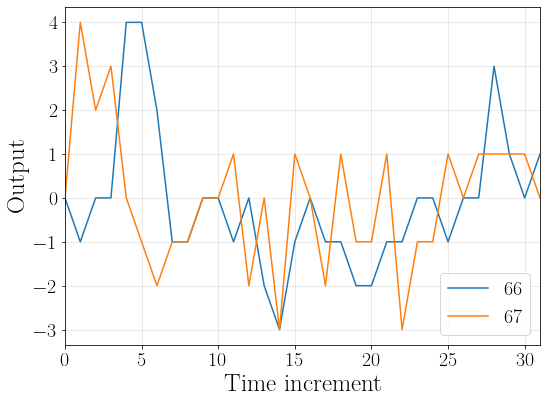

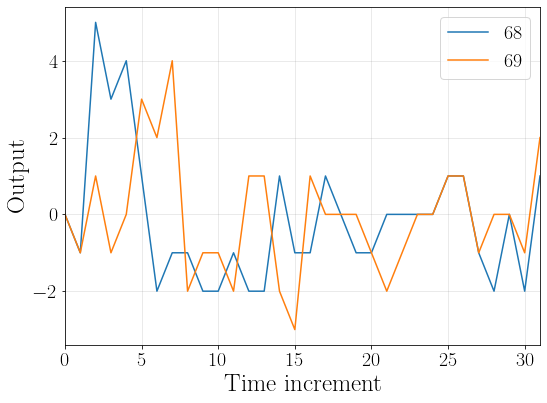

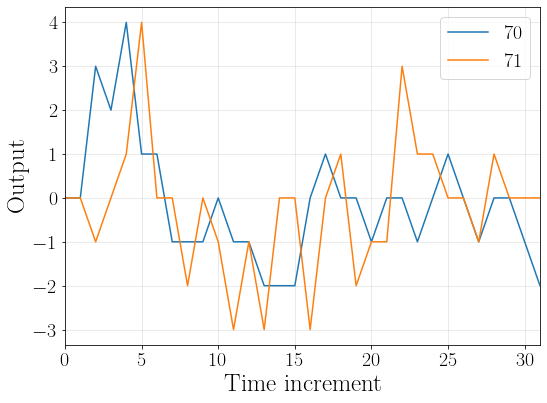

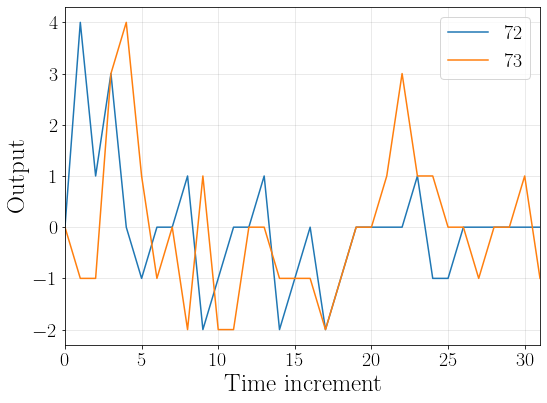

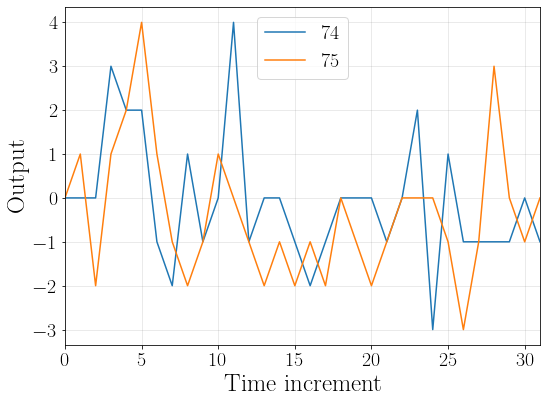

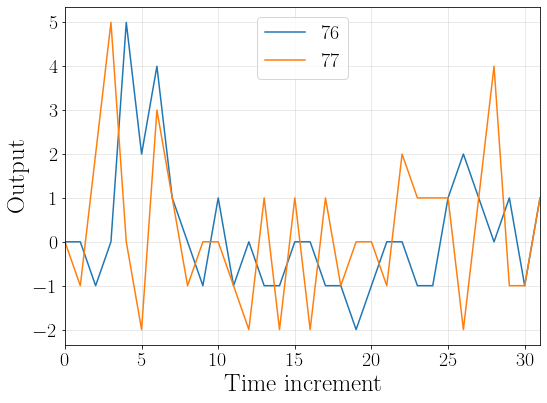

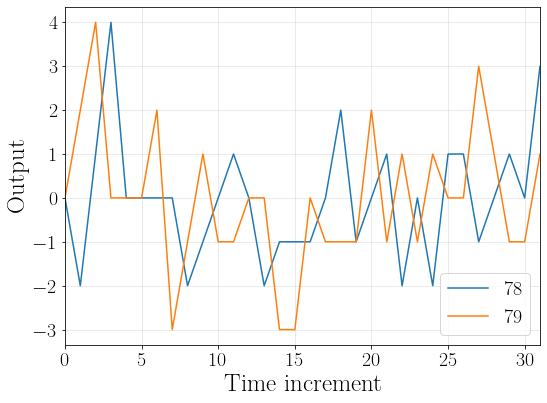

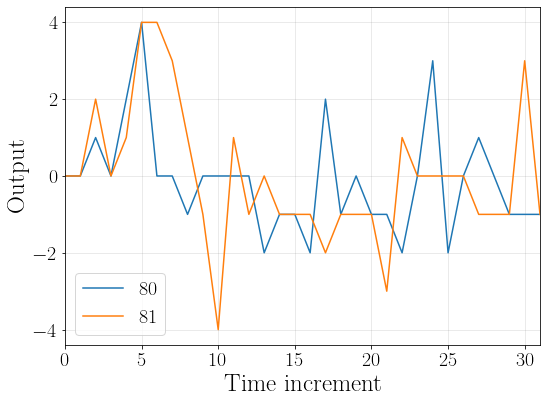

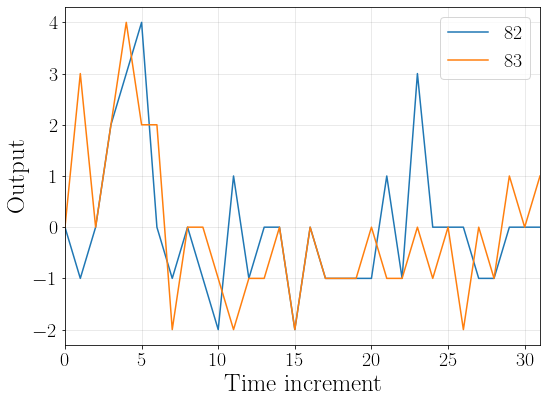

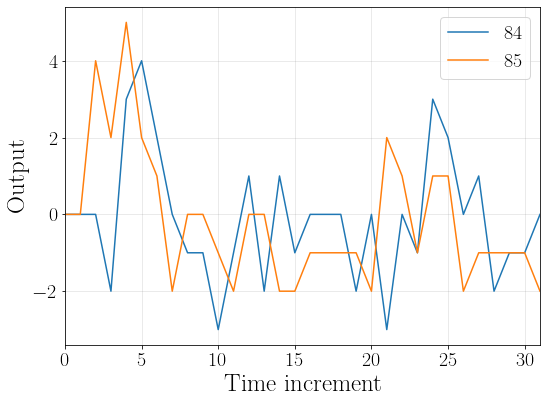

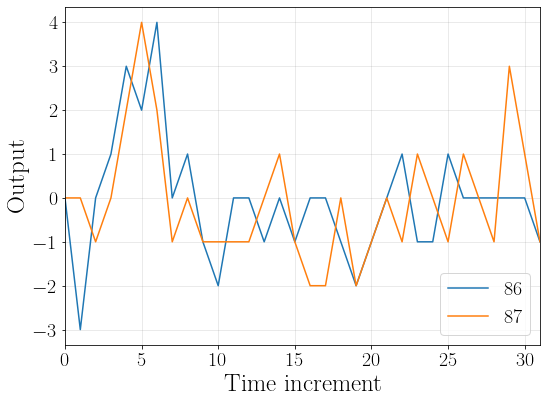

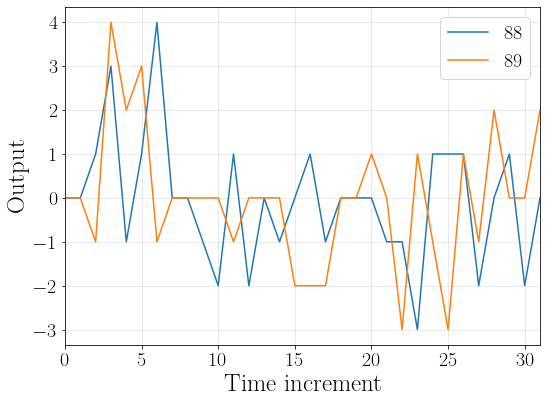

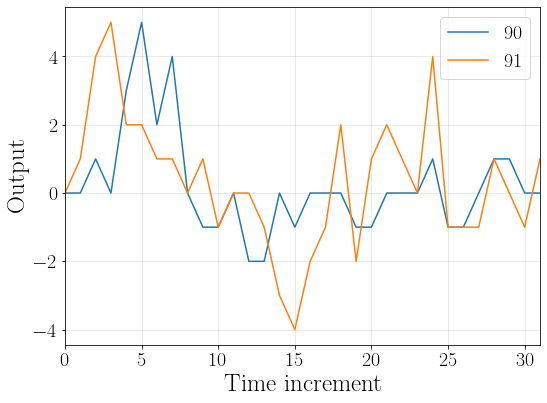

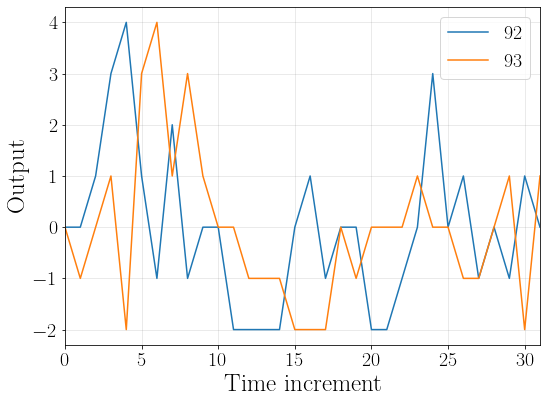

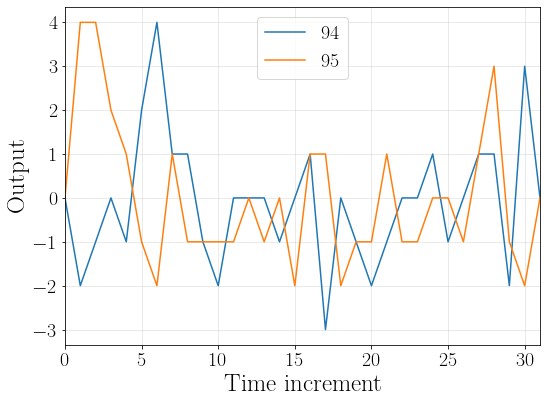

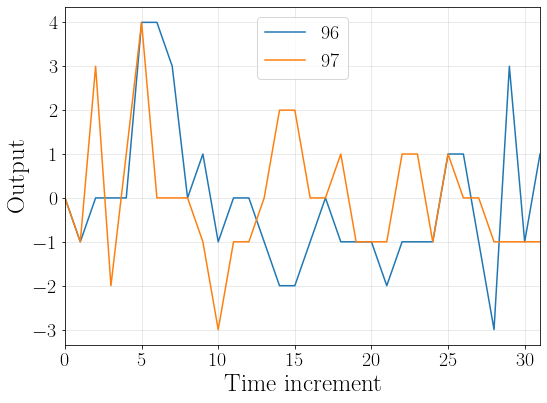

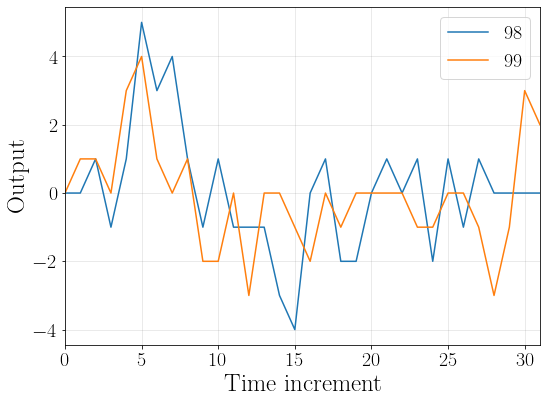

In [22]:
lp.plot_samples_lots(dataframe_sig_2_sample, minus_pedestal=True)